### Test finetuned YOLOv11


In [1]:
# ONLY RUN GOOGLE COLAB, Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cd /content/drive/MyDrive/'Colab Notebooks/human-activity-understanding/final-project'

/content/drive/MyDrive/Colab Notebooks/human-activity-understanding/final-project


### Install Ultralytics

In [2]:
get_ipython().system('pip install ultralytics')
print("ultralytics package installed.")

Looking in indexes: http://jetson.webredirect.org/jp6/cu126, https://pypi.ngc.nvidia.com
ERROR: Operation cancelled by user
^C
Looking in indexes: http://jetson.webredirect.org/jp6/cu126, https://pypi.ngc.nvidia.com
ERROR: Could not find a version that satisfies the requirement ultralytics (from versions: none)
ERROR: No matching distribution found for ultralytics
ultralytics package installed for Jetson Orin Nano.


In [7]:
import cv2
import numpy as np
import random

def draw_rect_boxes_and_labels(image, boxes, classes):
    """
    Draws rectangular bounding boxes and class labels on an image.
    """
    img_copy = image.copy()

    # Define a set of distinct colors for classes (BGR format for OpenCV)
    class_colors = [
      (0, 0, 70),   # person: bluelish
      (255, 165, 0), # case: orange
      (180, 100, 0),  # case_top:
      (0, 100, 100),  # battery: Grenn
      (128, 0, 128),   # screw: violet
      (0, 100, 0)  # tool: Green
    ]

    if boxes is not None and len(boxes) > 0:
        for box_data in boxes:
            x1, y1, x2, y2 = map(int, box_data.xyxy[0])
            class_id = int(box_data.cls[0])
            confidence = float(box_data.conf[0]) # Extract confidence score

            # Get color for the class
            color = class_colors[class_id % len(class_colors)] if class_id < len(class_colors) else (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # Fallback random color

            # Draw rectangle
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, 2)

            # Put label
            label = classes[class_id] if class_id < len(classes) else f"Unknown Class {class_id}"
            label_with_score = f"{label} {confidence:.2f}" # Append confidence score
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.4
            font_thickness = 1
            text_size = cv2.getTextSize(label_with_score, font, font_scale, font_thickness)[0]

            # Place text above the bounding box
            text_x = x1
            text_y = y1 - 10 if y1 - 10 > text_size[1] else y1 + text_size[1] + 10

            # Draw background for text
            cv2.rectangle(img_copy, (text_x, text_y - text_size[1] - 5),
                          (text_x + text_size[0] + 5, text_y + 5), color, -1)
            cv2.putText(img_copy, label_with_score, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    return img_copy


In [5]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the best trained model weights
model_path = os.path.join('runs', 'segment', 'yolov11n_seg_custom', 'weights', 'best.pt')
model = YOLO(model_path)

print(f"Loaded fine-tuned model from: {model_path}")


Loaded fine-tuned model from: runs/segment/yolov11n_seg_custom/weights/best.pt


KeyboardInterrupt: 

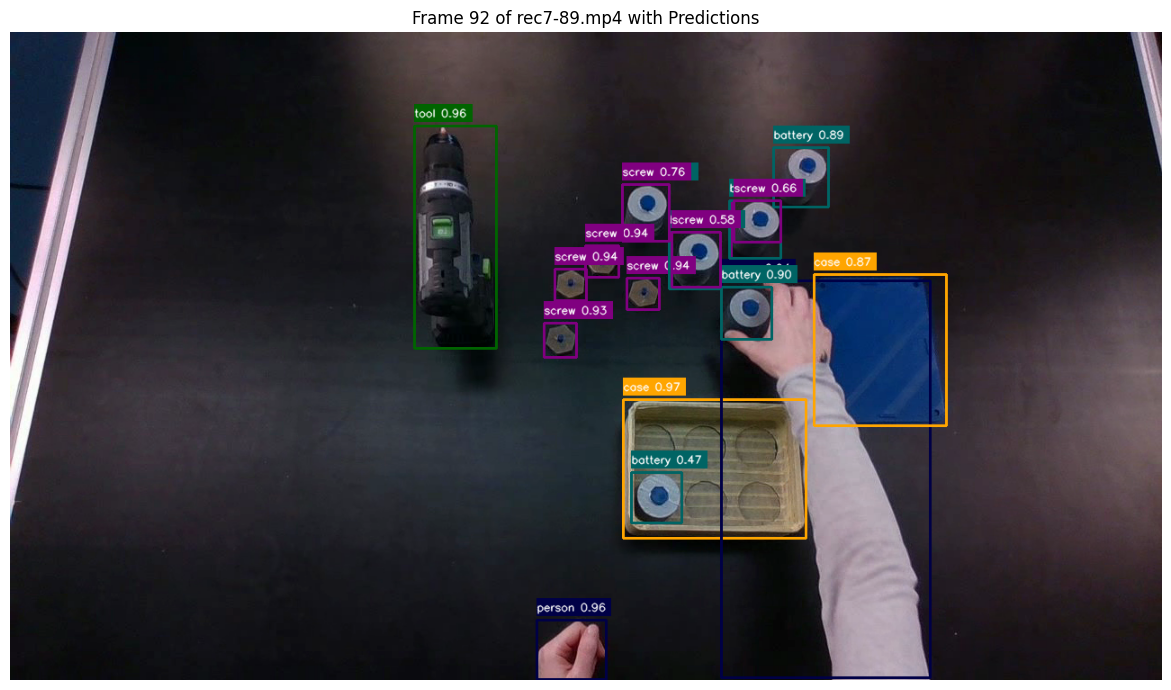

In [11]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np
from IPython.display import clear_output, display

# Define CLASSES (ensure it's in scope)
CLASSES = ["person", "case", "case_top", "battery", "screw", "tool"]

# Path to the video file
video_path = os.path.join('testdata', 'rec7-89.mp4')

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video file: {video_path}")

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("End of video or could not read frame.")
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Run inference
    results = model(img_rgb, verbose=False)

    # Collect all detected boxes for this frame
    all_detected_boxes = []
    for r in results:
        if hasattr(r, 'boxes') and r.boxes is not None and len(r.boxes) > 0:
            all_detected_boxes.extend(r.boxes)

    # Draw annotated frame
    img_with_predictions = draw_rect_boxes_and_labels(img_rgb.copy(), all_detected_boxes, CLASSES)

    # Display one frame at a time like a video
    clear_output(wait=True)
    plt.figure(figsize=(15, 7))
    plt.imshow(img_with_predictions)
    plt.title(f"Frame {frame_count} of {os.path.basename(video_path)} with Predictions")
    plt.axis('off')
    plt.tight_layout()
    display(plt.gcf())
    plt.close()
    # A short pause to mimic frame rate (adjust as needed)
    # You can use a longer or shorter delay, e.g., 0.04 for ~25fps, or press Enter to advance
    import time
    time.sleep(0.04)  # Or use 0.1 for a slower display

    frame_count += 1

cap.release()

print(f"Processed {frame_count} frames from video '{os.path.basename(video_path)}'.")


Visualizing 1 random validation images...


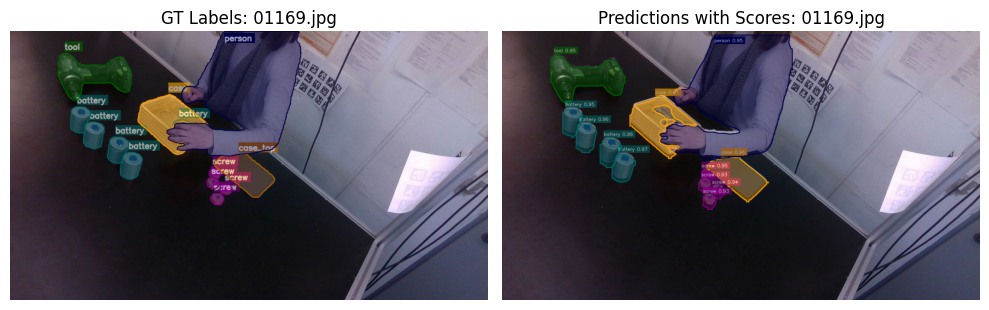

In [39]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np # Added numpy import

# Define a new helper function to draw masks with scores
def draw_masks_and_scores(image, masks_with_scores, classes):
    """
    Draws segmentation masks, class labels, and confidence scores on an image with semi-transparent colors.
    """
    img_copy = image.copy()
    overlay = img_copy.copy()
    alpha = 0.4  # Transparency factor

   # Define a set of distinct colors for classes (BGR format for OpenCV)
    class_colors = [
      (0, 0, 70),   # person: bluelish
      (255, 165, 0), # case: orange
      (180, 100, 0),  # case_top:
      (0, 100, 100),  # battery: Grenn
      (128, 0, 128),   # screw: violet
      (0, 100, 0)  # tool: Green
    ]

    for class_id, polygon_points, score in masks_with_scores:
        if polygon_points:
            # Get color for the class
            color = class_colors[class_id % len(class_colors)] if class_id < len(class_colors) else (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) # Fallback random color

            # Reshape points for cv2.fillPoly and cv2.polylines
            pts = np.array(polygon_points, np.int32)
            pts = pts.reshape((-1, 1, 2))

            # Fill the polygon on the overlay with semi-transparency
            cv2.fillPoly(overlay, [pts], color)

            # Draw polygon outline
            cv2.polylines(img_copy, [pts], True, color, 2)

            # Put label with score
            label_text = classes[class_id] if class_id < len(classes) else f"Unknown Class {class_id}"
            label_text = f"{label_text} {score:.2f}" # Add score here

            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.4
            font_thickness = 1
            text_size = cv2.getTextSize(label_text, font, font_scale, font_thickness)[0]

            # Place text near the first point of the polygon
            text_x = polygon_points[0][0]
            text_y = polygon_points[0][1] - 10 if polygon_points[0][1] - 10 > text_size[1] else polygon_points[0][1] + text_size[1] + 10

            # Draw background for text
            cv2.rectangle(img_copy, (text_x, text_y - text_size[1] - 5),
                          (text_x + text_size[0] + 5, text_y + 5), color, -1)
            cv2.putText(img_copy, label_text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    # Combine the original image with the overlay using the transparency factor
    img_with_masks = cv2.addWeighted(overlay, alpha, img_copy, 1 - alpha, 0)
    return img_with_masks


print(f"Visualizing {num_images_to_visualize} random validation images...")

plt.figure(figsize=(10, 5))

for i, img_filename in enumerate(selected_images_for_viz):
    img_path = os.path.join(val_images_dir, img_filename)
    label_filename = os.path.splitext(img_filename)[0] + '.txt'
    label_path = os.path.join(val_labels_dir, label_filename)

    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image: {img_path}")
        continue

    # OpenCV reads images as BGR, convert to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get image dimensions for parsing labels
    img_height, img_width, _ = img_rgb.shape

    # --- Ground Truth Labels ---
    gt_masks = parse_yolo_label(label_path, img_width, img_height)
    img_with_gt = draw_bboxes_and_labels(img_rgb.copy(), gt_masks, CLASSES)

    # --- Model Predictions ---
    # Run inference
    results = model(img_rgb, verbose=False) # verbose=False to suppress output for each image

    # Process results to get masks in the desired format
    predicted_masks_with_scores = []
    for r in results:
        if r.masks is not None:
            for j, mask_data in enumerate(r.masks.data):
                class_id = int(r.boxes.cls[j])
                confidence_score = float(r.boxes.conf[j]) # Get confidence score
                # Convert mask to polygon points
                mask_np = mask_data.cpu().numpy().astype(np.uint8)
                contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if contours:
                    # Take the largest contour for simplicity if multiple are found
                    contour = max(contours, key=cv2.contourArea)
                    # Reshape to (N, 2) list of tuples for draw_masks_and_scores
                    polygon_points = [tuple(point[0]) for point in contour]
                    predicted_masks_with_scores.append((class_id, polygon_points, confidence_score)) # Append score

    # Draw bounding boxes and labels using the newly defined helper function
    img_with_predictions = draw_masks_and_scores(img_rgb.copy(), predicted_masks_with_scores, CLASSES)

    # --- Display Both ---
    plt.subplot(num_images_to_visualize, 2, i * 2 + 1) # First column for GT
    plt.imshow(img_with_gt)
    plt.title(f"GT Labels: {img_filename}")
    plt.axis('off')

    plt.subplot(num_images_to_visualize, 2, i * 2 + 2) # Second column for Predictions
    plt.imshow(img_with_predictions)
    plt.title(f"Predictions with Scores: {img_filename}")
    plt.axis('off')

plt.tight_layout()
plt.show()

